In [173]:
import pandas as pd
import numpy as np
import scipy.stats
import random
from sklearn import preprocessing

# geo
from pygeotile.tile import Tile
from geopy.geocoders import Nominatim

#
import imp
import plot_maps as pm
imp.reload(pm)
%matplotlib inline

In [174]:
R = 0.02
def metrics(lat_hat, lon_hat, lat_real, lon_real):
    lat = np.power(lat_hat - lat_real, 2)
    lon = np.power(lon_hat - lon_real, 2)
    return np.power(lat + lon, 0.5) < R

def score(predictions_home, predictions_work, real_coords_home, real_coords_work):
    score = 0
    for pred_h, real_h, pred_w, real_w in list(zip(predictions_home, real_coords_home
                                                   , predictions_work, real_coords_work)):
        
        m_h = metrics(pred_h[0], pred_h[1], real_h[0], real_h[1])
        m_w = metrics(pred_w[0], pred_w[1], real_w[0], real_w[1])
        score = score + (m_h + m_w) / 2

                    
    return score / len(predictions_home)

In [175]:
# функция выбирает те терминалы, которые могут иметь несколько координат на карте, но расположены недалеко друг от друга
# по умолчанию оставим значение ~ равное "терминал мог изменить своё местоположение внутри района - города"
def short_distance_terminals(df, threshold = 0.1):
    min_coords_lat = df_train.groupby(['terminal_id'])['tran_lat'].min().reset_index(name='min_lat')
    max_coords_lat = df_train.groupby(['terminal_id'])['tran_lat'].max().reset_index(name='max_lat')
    min_coords_lon = df_train.groupby(['terminal_id'])['tran_lon'].min().reset_index(name='min_lon')
    max_coords_lon = df_train.groupby(['terminal_id'])['tran_lon'].max().reset_index(name='max_lon') 
    
    coords_diff = max_coords_lat
    coords_diff['min_lat'] = min_coords_lat['min_lat'] 
    coords_diff['min_lon'] = min_coords_lon['min_lon']
    coords_diff['max_lon'] = max_coords_lon['max_lon']  
    coords_diff['diff_lat'] = abs(coords_diff['min_lat'] - coords_diff['max_lat'])
    coords_diff['diff_lon'] = abs(coords_diff['min_lon'] - coords_diff['max_lon'])
    
    good_terminals = coords_diff[(coords_diff.diff_lat < threshold) &
                                 (coords_diff.diff_lon < threshold)]['terminal_id'].unique()
    return good_terminals

# объединяем координаты транзакции  под одни колонки (*_1 может быть нулевой, порядок агрументов важен)
def concat_coords(dataframe, concat_lat_1, concat_lon_1, concat_lat_2, concat_lon_2):
    dataframe['tran_lat'] = np.where(dataframe[concat_lat_1].isnull(),
                                    dataframe[concat_lat_2], dataframe[concat_lat_1])
    dataframe['tran_lon'] = np.where(dataframe[concat_lon_1].isnull(),
                                    dataframe[concat_lon_2], dataframe[concat_lon_1])
    return dataframe

# если у терминала одна координата - оставить. Если много - заменить средним
def change_coords_by_mean(dataframe):
    # число уникальных гео координат на терминал
    terminals_unique_pos = dataframe.groupby('terminal_id')['trans_pos'].nunique().reset_index(name = 'count')
    dual_terminal_pos = terminals_unique_pos[terminals_unique_pos['count'] > 1]['terminal_id']
    
    # оставляем те, что встречаются больше одного раза и заменяем средним
    tmp = dataframe[dataframe['terminal_id'].isin(dual_terminal_pos)]
    terminals_mean = tmp.groupby('terminal_id')[['tran_lat','tran_lon']].apply(np.mean).reset_index()
    
    dataframe = dataframe.merge(terminals_mean, how = 'left', left_on = 'terminal_id', right_on = 'terminal_id')
#     print (dataframe.columns.values)
    dataframe = concat_coords(dataframe, 'tran_lat_y', 'tran_lon_y', 'tran_lat_x', 'tran_lon_x')
    dataframe.drop(['tran_lat_y', 'tran_lon_y', 'tran_lat_x', 'tran_lon_x'], axis = 1, inplace = True)
    del tmp
    return dataframe
    
# предобработка исходных данных. Удаление ненужных столбцов  и плохих терминалов.
def preprosses(dataframe, df_mcc):
    
    num_old_trans = dataframe.shape[0]
    num_old_cust_ids = dataframe['customer_id'].nunique()
    num_old_term_ids = dataframe['terminal_id'].nunique()
    print ('Before data preprossesing\n shape: %d, unique clients: %d, unique terminals: %d' 
                           %(num_old_trans, num_old_cust_ids, num_old_term_ids))
    # объединим координаты банкоматов и прочих транзакций, сформировав единое представление о координатах
    dataframe = concat_coords(dataframe, 'atm_address_lat', 'atm_address_lon'
                                       , 'pos_adress_lat','pos_adress_lon')
    
    dataframe = pd.merge(dataframe, df_mcc, left_on = 'mcc', right_on='MCC')
    
    # те mcc коды, которые не смержились, можно убрать
    dataframe = dataframe[~dataframe["Description_1_code"].isnull()]
    # кафе и фастфуд будем считать одним и тем же
    dataframe['Description_1_code']  = dataframe['Description_1_code'].replace({41: 19})  
    

    
    
    dataframe = dataframe[dataframe['country'].isin(['RUS','RU'])]
    
    # эти колонки больше не нужны
    dataframe.drop(['MCC'
                    ,'pos_adress_lat','pos_adress_lon'
                    ,'atm_address_lat','atm_address_lon'
                    ,'atm_address'], axis = 1, inplace = True)
   
    # редкие mcc объединим в одно
    tmp = dataframe['Description_1_code'].value_counts().reset_index(name = 'count')
    rare_mcc = tmp[tmp['count'] < 500].index
    dataframe.loc[dataframe['Description_1_code'].isin(rare_mcc), 'Description_1_code'] = 'rare'
    
    # mcc_common -> dummies
    dataframe['mcc_common'] = dataframe['Description_1_code']
    dataframe = pd.get_dummies(dataframe, columns=["Description_1_code"])
    
    # удаляем те терминалы, которые без географической привязки. По заданному адресу их сложно восстановить.
    terminals = dataframe[dataframe['mcc_common'] == 22]
    nan_terminals = terminals[terminals['tran_lat'].isnull()]['terminal_id'].unique()
    dataframe  = dataframe[~dataframe['terminal_id'].isin(nan_terminals)]

    # убираем те терминалы, которые меняли свою привзяку по mcc
    terminals_count = dataframe.groupby('terminal_id')['mcc_common'].nunique().reset_index(name = 'count')
    dual_mcc_terminals = terminals_count[terminals_count['count'] > 1]
    dataframe = dataframe[~dataframe['terminal_id'].isin(dual_mcc_terminals)]
    
    # убираем терминалы, которые "двигались" в пространстве
    good_terminals = short_distance_terminals(dataframe, 0.2)
    dataframe = dataframe[dataframe['terminal_id'].isin(good_terminals)]
    
    # неработающих/бездомных  отправляем в атлантический океан
    dataframe['work_add_lat'].fillna(0.0, inplace = True)
    dataframe['work_add_lon'].fillna(0.0, inplace = True)
    dataframe['home_add_lat'].fillna(0.0, inplace = True)
    dataframe['home_add_lon'].fillna(0.0, inplace = True)
    
    # для термиалов, которые имеют много географических значений - заменяем средним.
    dataframe['trans_pos'] = list(zip(dataframe['tran_lat'], dataframe['tran_lon']))
    dataframe = change_coords_by_mean(dataframe)  
    dataframe['trans_pos'] = list(zip(dataframe['tran_lat'], dataframe['tran_lon']))
    
    print ('After data preprossesing\n shape: %d, unique clients: %d, unique terminals: %d' 
                           %(dataframe.shape[0], dataframe['customer_id'].nunique(), dataframe['terminal_id'].nunique()))    
    return dataframe

In [176]:
df_train = pd.read_csv('data/train_set.csv', low_memory=False)

In [177]:
df_mcc = pd.read_excel('data/mcc.xlsx')
df_mcc = df_mcc[['MCC', 'Description_1_code']]
df1 = preprosses(df_train, df_mcc)

Before data preprossesing
 shape: 1224734, unique clients: 10000, unique terminals: 208383
After data preprossesing
 shape: 1121570, unique clients: 10000, unique terminals: 190216


In [178]:
df_train = pd.merge(df_train, df_mcc, left_on = 'mcc', right_on='MCC')
df_train['mcc_common'] = df_train["Description_1_code"]

In [179]:
pm.plot_terminal('003a2261c86b4210d0de1657dfa17b86', df_train)

In [180]:
pm.plot_terminal('003a2261c86b4210d0de1657dfa17b86', df1)

Видим, что городов очень много. Стоит расмотреть следущие варианты:
    - заменить редкие попадания на 'other', большие города объединить
    - если в тех городах никто не живёт - выкинуть из рассмотрения
    - тайлировать координаты, чтобы избавиться от этой переменной
    - использовать osmapi чтобы получить реальные города

In [181]:
pm.plot_one_person('0dc0137d280a2a82d2dc89282450ff1b', df_train)

   home_add_lat  home_add_lon
0        59.851        30.232
   work_add_lat  work_add_lon
0        59.847        30.177


In [182]:
pm.plot_one_person('0dc0137d280a2a82d2dc89282450ff1b', df1)

   home_add_lat  home_add_lon
0        59.851        30.232
   work_add_lat  work_add_lon
0        59.847        30.177


In [183]:
df1.head()

,amount,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,terminal_id,...,Description_1_code_23,Description_1_code_38,Description_1_code_39,Description_1_code_42,Description_1_code_43,Description_1_code_45,Description_1_code_rare,trans_pos,tran_lat,tran_lon
0,2.884034,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,11606fde0c814ce78e0d726e39a0a5ee,...,0,0,0,0,0,0,0,"(59.84407235, 30.1791526293)",59.844072,30.179153
1,2.775633,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,e9647a5e1eacfb06713b6af755ccc595,...,0,0,0,0,0,0,0,"(59.84407235, 30.1791526293)",59.844072,30.179153
2,2.787498,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,6c5e5793ebc984fb72875feffff62854,...,0,0,0,0,0,0,0,"(59.84407235, 30.1791526293)",59.844072,30.179153
3,2.892510,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,0576445d74e374c92c0902e612fca356,...,0,0,0,0,0,0,0,"(59.84407235, 30.1791526293)",59.844072,30.179153
4,2.909018,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,af0d099257ccedbfe730c63a491e0d84,...,0,0,0,0,0,0,0,"(59.84407235, 30.1791526293)",59.844072,30.179153


Стратегия:
    - мы будем предсказывать близость транзакции к дому или работе (две задачи классификации)
    - отберём таким образом терминалы с самой высокой вероятностью принадлежности к дому/работе
    - посчитаем средние таких терминалов. Это и будет ответом

In [184]:
# посчитаем для каждого терминала в разрезе пользователя, ближе он к дому или работе. 
def target(dataframe, threshold = 0.02):
    dataframe['near_home'] = (np.sqrt((dataframe['tran_lat'] - dataframe['home_add_lat'])**2 +
                                       (dataframe['tran_lon'] - dataframe['home_add_lon'])**2) < threshold).astype(int)
    dataframe['near_work'] = (np.sqrt((dataframe['tran_lat'] - dataframe['work_add_lat'])**2 +
                                       (dataframe['tran_lon'] - dataframe['work_add_lon'])**2) < threshold).astype(int)
    return dataframe 

In [185]:
df1 = target(df1)

In [186]:
# создание тайла определённого масштаба (train + test)
def create_zoom_tile(dataframe, zoom):
    list_tiles_zoom = []
    for ix, row in dataframe.iterrows():
        list_tiles_zoom.append(Tile.for_latitude_longitude(row['tran_lat'], row['tran_lon'], zoom))     
    dataframe['tile_' + str(zoom)] = list_tiles_zoom
    le = preprocessing.LabelEncoder().fit(dataframe['tile_' + str(zoom)])
    dataframe['tile_number_' +str(zoom) ] = le.transform(dataframe['tile_' + str(zoom)])
    return dataframe
    
# создание тайлов для конкретных масштабов
def create_tiles(dataframe, list_zooms):
    for zoom in list_zooms:
        dataframe = create_zoom_tile(dataframe, zoom)
    
    return dataframe

def calculate_num_of_near_trans(dataframe, tile_column):
    num_of_near_trans = dataframe.groupby(tile_column).size().reset_index(name = 'num_near_trans_' + tile_column)
    dataframe = dataframe.merge(num_of_near_trans, how  = 'left', left_on = tile_column, right_on = tile_column)
    return dataframe

def calculate_num_of_near_terminals(dataframe, tile_column):
    num_of_near_trerminals = dataframe.groupby(tile_column)['terminal_id'].nunique().reset_index(name = 'num_near_terminal_' + tile_column)
    dataframe = dataframe.merge(num_of_near_trerminals, how  = 'left', left_on = tile_column, right_on = tile_column)
    return dataframe

In [187]:
%%time
df1 = create_tiles(df1, [10, 13, 15, 17])

Wall time: 8min 45s


In [188]:
df1.head(100)

,amount,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,terminal_id,...,near_home,near_work,tile_10,tile_number_10,tile_13,tile_number_13,tile_15,tile_number_15,tile_17,tile_number_17
0,2.884034,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,11606fde0c814ce78e0d726e39a0a5ee,...,0,1,"(597, 725, 10)",96,"(4782, 5805, 13)",371,"(19130, 23223, 15)",832,"(76523, 92895, 17)",1405
1,2.775633,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,e9647a5e1eacfb06713b6af755ccc595,...,0,1,"(597, 725, 10)",96,"(4782, 5805, 13)",371,"(19130, 23223, 15)",832,"(76523, 92895, 17)",1405
2,2.787498,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,6c5e5793ebc984fb72875feffff62854,...,0,1,"(597, 725, 10)",96,"(4782, 5805, 13)",371,"(19130, 23223, 15)",832,"(76523, 92895, 17)",1405
3,2.892510,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,0576445d74e374c92c0902e612fca356,...,0,1,"(597, 725, 10)",96,"(4782, 5805, 13)",371,"(19130, 23223, 15)",832,"(76523, 92895, 17)",1405
4,2.909018,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,af0d099257ccedbfe730c63a491e0d84,...,0,1,"(597, 725, 10)",96,"(4782, 5805, 13)",371,"(19130, 23223, 15)",832,"(76523, 92895, 17)",1405
5,2.801228,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,0576445d74e374c92c0902e612fca356,...,0,1,"(597, 725, 10)",96,"(4782, 5805, 13)",371,"(19130, 23223, 15)",832,"(76523, 92895, 17)",1405
6,2.838200,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,0576445d74e374c92c0902e612fca356,...,0,1,"(597, 725, 10)",96,"(4782, 5805, 13)",371,"(19130, 23223, 15)",832,"(76523, 92895, 17)",1405
7,3.264740,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,bcb3d58edc38eefade93d916db39b25f,...,0,1,"(597, 725, 10)",96,"(4782, 5805, 13)",371,"(19130, 23223, 15)",832,"(76523, 92895, 17)",1405
8,3.118792,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,7fa36740d3d66ed86f69f5b3578de264,...,0,1,"(597, 725, 10)",96,"(4782, 5805, 13)",371,"(19130, 23223, 15)",832,"(76523, 92895, 17)",1405
9,3.681148,HIMKI,RUS,643.0,19b1319d29fd9d85ce9bfee83e42d51f,55.890,37.561,5261,NaN,55f88c2e594631c2886aaf111dbde228,...,0,0,"(618, 704, 10)",545,"(4947, 5637, 13)",1966,"(19789, 22548, 15)",5391,"(79158, 90194, 17)",12374


In [189]:
df1[df1['customer_id'] == '0dc0137d280a2a82d2dc89282450ff1b'].tile_17.unique()

array([Tile(tms_x=76523, tms_y=92895, zoom=17),
       Tile(tms_x=76542, tms_y=92905, zoom=17),
       Tile(tms_x=76549, tms_y=92905, zoom=17),
       Tile(tms_x=76555, tms_y=92900, zoom=17),
       Tile(tms_x=76539, tms_y=92902, zoom=17),
       Tile(tms_x=76541, tms_y=92905, zoom=17),
       Tile(tms_x=76517, tms_y=92868, zoom=17),
       Tile(tms_x=76600, tms_y=93048, zoom=17)], dtype=object)

In [190]:
df1 = calculate_num_of_near_trans(df1, 'tile_number_13')
df1 = calculate_num_of_near_trans(df1, 'tile_number_15')
df1 = calculate_num_of_near_trans(df1, 'tile_number_17')

df1 = calculate_num_of_near_terminals(df1, 'tile_number_13')
df1 = calculate_num_of_near_terminals(df1, 'tile_number_15')
df1 = calculate_num_of_near_terminals(df1, 'tile_number_17')

In [191]:
df1.head()

,amount,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,terminal_id,...,tile_15,tile_number_15,tile_17,tile_number_17,num_near_trans_tile_number_13,num_near_trans_tile_number_15,num_near_trans_tile_number_17,num_near_terminal_tile_number_13,num_near_terminal_tile_number_15,num_near_terminal_tile_number_17
0,2.884034,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,11606fde0c814ce78e0d726e39a0a5ee,...,"(19130, 23223, 15)",832,"(76523, 92895, 17)",1405,2707,1067,1060,335,93,90
1,2.775633,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,e9647a5e1eacfb06713b6af755ccc595,...,"(19130, 23223, 15)",832,"(76523, 92895, 17)",1405,2707,1067,1060,335,93,90
2,2.787498,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,6c5e5793ebc984fb72875feffff62854,...,"(19130, 23223, 15)",832,"(76523, 92895, 17)",1405,2707,1067,1060,335,93,90
3,2.892510,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,0576445d74e374c92c0902e612fca356,...,"(19130, 23223, 15)",832,"(76523, 92895, 17)",1405,2707,1067,1060,335,93,90
4,2.909018,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,af0d099257ccedbfe730c63a491e0d84,...,"(19130, 23223, 15)",832,"(76523, 92895, 17)",1405,2707,1067,1060,335,93,90


In [172]:
# данный вызов рисует не 93 терминала в разбросе, увы, на одну точку приходится много терминалов
# pm.plot_transactions_in_tile(df1, 'tile_number_15', 832)

### Генерация фичей

Идеи, которые будем реализовывать:
    + разобьём всю карту на небольшие квадраты (по прообразу тайлов в google maps)
    + для каждой транзакции создадим набор фичей: номер тайла зума n (предлположительно n ~ 15-18, для достаточно малых масштабов) и один чуть побольше, чтобы можно было пересчитать город
    + для каждой транзакции исходя из зума тайла n посчитать, сколько транзакций/терминалов ещё входит в этот тайл (плотность тайла)
    - день недели(dummies)
    - распределение трат mcc кодов для клиента
    - описание района транзакции (если успею): openstreetmap shapes
    - статистики: средние транзакции клиента по координатам
    - удалённость транзакции клиента от среднего

In [192]:
dict_cust2trans = df1.groupby("customer_id").size().to_dict()
df['count_all_transactions'] = df['customer_id'].map(dict_cust2trans)

In [193]:
mapping_all

{'0001f322716470bf9bfc1708f06f00fc': 50,
 '0007297d86e14bd68bd87b1dbdefe302': 236,
 '000b709c6c6fb1e8efcfd95e57c2a9de': 39,
 '0027a7618d97cc9fbda55fac457eaeb7': 13,
 '002b9f6e118c54f1292e03d1a04d516e': 153,
 '0031915eb230f772681fb5dc5a8d1c31': 155,
 '003360bff9882ca4a4f93394dd984822': 62,
 '0037f3de3d890df1022cc760a1dfd9d6': 73,
 '003fa58414cc55531fcc38423bea8f8e': 206,
 '0046c2952fb808aa11f74abce5abe097': 107,
 '005194bf7238734eb49c142258c5a263': 146,
 '0055a1c72c44451165c872cd992c1d90': 43,
 '005d6f1ee97276374cefe4d0c65e9a89': 91,
 '006e9e0d6587c61da4317b8a6935a7bd': 42,
 '007525af0bc3ce72137b586a298f7b98': 24,
 '007a45db1a78be386e368612dd59be77': 132,
 '007bb42c2a4eb9aa33f9bc5abae7632f': 22,
 '0086aa6c4ebc89dd5a20eed71a625df1': 137,
 '00873fbbbd0790580594afcc0fe8ead8': 102,
 '0089100aa33a523bd2e697dec264a71a': 337,
 '008b0844115d2c7aafe51ccb3c4b2c2e': 89,
 '008cc8d9598253a86b219815aa0bc643': 38,
 '0098b0f7ec0a361fb6c483ca63596f03': 164,
 '009f05416473981238824dd50cad1b66': 242,
 '00

Получается, что кто-то переезжал, а кто-то безработный, а у кого-то несколько работ

In [94]:
#Похоже, у некоторых людей несколько адресов
adress_home = df_train[['home_add_lat','home_add_lon']].drop_duplicates()
print (adress_home.shape)
# а чуть более не работают
adress_work = df_train[['work_add_lat','work_add_lon']].drop_duplicates()
print (adress_work.shape)

(10147, 2)
(4585, 2)


In [95]:
df_train.groupby('customer_id')['city'].apply(set).head()

customer_id
0001f322716470bf9bfc1708f06f00fc    {TSEMDOLINA S., NOVOROSIYSK, NOVOROSSIIYSK, NO...
0007297d86e14bd68bd87b1dbdefe302    {MOSCOW       , Moskva, MOSKOW, MOSKVA       ,...
000b709c6c6fb1e8efcfd95e57c2a9de    {KEMEROVO, NVSIBR, IRKUTSK, DOMODEDOVO, TOMSK ...
0027a7618d97cc9fbda55fac457eaeb7    {LESNOJ GORODO, LESNOY, MOSCOW, YUDINO, VARNA ...
002b9f6e118c54f1292e03d1a04d516e    {MOSCOW       , G MOSKVA, Rhodes       , Moskv...
Name: city, dtype: object

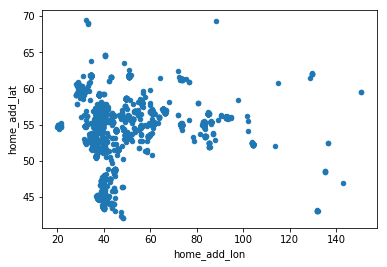

In [96]:
#Что-ж, картинка слабо напоминает хоть что-то, попробуем визуализировать кусками, похоже, что есть ошибки
adress_home_msk = df_train[['home_add_lat','home_add_lon']].drop_duplicates()
adress_home_msk.plot(y = 'home_add_lat', x = 'home_add_lon', kind = 'scatter');

In [97]:
# загрузим упрощённое описание mcc кодов
df_mcc = pd.read_excel('data/mcc.xlsx')
df_mcc = df_mcc[['MCC', 'Description_1_code']]
df_train = preprosses(df_train, df_mcc)

10000


In [104]:
adress_home_msk = adress_home_msk.fillna(0)

In [105]:
adress_home_msk.shape

(10147, 2)

In [ ]:
#  ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
#  |           'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
#  |           'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
#  |           'gray', 'black', 'lightgray']

In [106]:
plot_one_person('0dc0137d280a2a82d2dc89282450ff1b', df1)

   home_add_lat  home_add_lon
0        59.851        30.232
   work_add_lat  work_add_lon
0        59.847        30.177


In [226]:
customers = df_train['customer_id'].unique()

In [227]:
random.shuffle(customers)

In [228]:
for c in customers[0:10]:
    plot_one_person(c, df_train)

        home_add_lat  home_add_lon
228180        53.841         37.34
        work_add_lat  work_add_lon
228180        54.186        37.547
       home_add_lat  home_add_lon
12967        55.757        37.855
       work_add_lat  work_add_lon
12967        55.791         37.61
        home_add_lat  home_add_lon
217819        55.764        37.586
        work_add_lat  work_add_lon
217819        55.771        37.641
        home_add_lat  home_add_lon
213226         44.68        37.795
Empty DataFrame
Columns: [work_add_lat, work_add_lon]
Index: []
        home_add_lat  home_add_lon
357333         55.83        37.329
        work_add_lat  work_add_lon
357333        55.744        37.436
     home_add_lat  home_add_lon
204        55.724        37.599
     work_add_lat  work_add_lon
204        55.747        37.404
      home_add_lat  home_add_lon
5165        58.601        49.663
      work_add_lat  work_add_lon
5165        58.602        49.678
        home_add_lat  home_add_lon
214769        5

Очень многие банкоматы не имеют координат, это плохо: но попробуем восстановить через имеющийся адрес

In [14]:
df_train.shape

(1224734, 15)

In [131]:
# те mcc коды, которые не смержились, можно убрать
df_train = df_train[~df_train["Description_1_code"].isnull()]

In [139]:
#гипотеза 1: покупает дома в магазинах, на работе ходит в кафе-рестораны

In [141]:
df_train_hup_1 = df_train[df_train['Description_1_code'].isin([10,19])]

In [149]:
# df_train_hup_1.groupby(['customer_id','Description_1_code'])['Description_1_code'].count()

In [213]:
clients_h = df_train[['customer_id','home_add_lat','home_add_lon']].drop_duplicates()
clients_w = df_train[['customer_id','work_add_lat','work_add_lon']].drop_duplicates()

real_h_coords = list(zip(clients_h['home_add_lat'],clients_h['home_add_lon']))
real_w_coords = list(zip(clients_w['work_add_lat'],clients_w['work_add_lon']))

In [214]:
score(real_h_coords, real_w_coords, real_h_coords, real_w_coords)

0.5036277449937119

In [228]:
tmp = df_train.groupby(['customer_id','terminal_id'])['terminal_id'].count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             

In [279]:
terminals = df_train[['terminal_id','tran_lat','tran_lon']].drop_duplicates()
terminals.terminal_id.nunique()
terminals_mcc = df_train[['terminal_id', 'Description_1_code']].drop_duplicates()

In [251]:
# terminals1 = terminals.groupby('terminal_id')[['tran_lat','tran_lon']].apply(np.mean)
# terminals1 = terminals.reset_index()

In [280]:
# terminals1 = terminals1.merge(terminals_mcc, left_on = 'terminal_id', right_on = 'terminal_id')

In [281]:
# df_train.terminal_id.nunique()

In [282]:
# tmp.merge(terminals1, left_on = 'terminal_id', right_on = 'terminal_id')

In [283]:
df_train.transaction_date.min()
df_train.transaction_date.max()

'2017-01-27'

In [285]:
# отобразить клиента и его самые частые транзакции
# один терминал - один mcc - одна координата
# один клиент - одна координата (last transaction)
# сделать сабмит клиент - самая часто встречающаяся координата

In [299]:
terminals_mcc = terminals_mcc.groupby('terminal_id')['terminal_id'].count().reset_index(name='count')

In [302]:
terminals_mcc = terminals_mcc[terminals_mcc['count'] == 1]

In [304]:
df_train = df_train[df_train.terminal_id.isin(terminals_mcc.terminal_id)]

In [82]:
max_coords_lat['diff_lat'] = abs(max_coords_lat['min_lat'] - max_coords_lat['max_lat'])
max_coords_lat['diff_lon'] = abs(max_coords_lat['min_lon'] - max_coords_lat['max_lon'])

In [83]:
# max_coords_lat = max_coords_lat[(max_coords_lat.diff_lat < 0.02) & (max_coords_lat.diff_lon < 0.02)]

In [84]:
max_coords_lat.sort_values(by = 'diff_lat', ascending = False).head()

,terminal_id,max_lat,min_lat,min_lon,max_lon,diff_lat,diff_lon
151831,baa32ae2c1f8486cbf47507e0554e627,61.666968,43.650585,39.656114,50.790304,18.016384,11.134190
116553,8f309f3e5dd1aa2df490c4b641193c5b,59.949370,44.833184,30.359035,37.582340,15.116186,7.223305
97988,784e57fb245ea05c70f654b637f20c45,59.949370,44.833184,30.359035,37.582340,15.116186,7.223305
199119,f4a3742f7e38459907b26052a21ea85d,59.949370,44.833184,30.359035,37.582340,15.116186,7.223305
73935,5af26e3e2e7623af07b463107a0006af,60.061450,45.016750,30.392647,38.793393,15.044700,8.400746


In [77]:
def plot_terminal(terminal_id, df):
    transactions_disct = df[df['terminal_id'] == terminal_id][['terminal_id','mcc_common', 'tran_lat', 'tran_lon']].drop_duplicates()

    map_osm = folium.Map(location=[transactions_disct.iloc[0]['tran_lat'],transactions_disct.iloc[0]['tran_lon']])
    dict_icons = {22: 'credit-card', 10: 'shopping-cart', 19: 'beer'}
    dict_colors = {22: 'green', 10: 'lightblue', 19: 'orange'}
    
    for idx, trans in transactions_disct.iterrows():
        color = dict_colors.get(trans['mcc_common'], "pink")
        icon = dict_icons.get(trans['mcc_common'], "info-sign")
        folium.Marker([trans['tran_lat'], trans['tran_lon']],
               popup=trans['terminal_id'],
              icon=folium.Icon(color=color, icon=icon)
              ).add_to(map_osm)
    return map_osm

In [113]:
plot_terminal('97b421fd894007e250dab809624c995b', df1)

In [330]:
df_train = df_train[df_train.terminal_id.isin(max_coords_lat.terminal_id)]

In [331]:
df_train.shape

(1118923, 17)

In [336]:
df_train = df_train.set_index('customer_id')

In [401]:
df_train['my_dates'] = pd.to_datetime(df_train['transaction_date'])
df_train['day_of_week'] = df_train['my_dates'].dt.dayofweek

In [402]:
predictors = ['amount','currency', 'mcc','tran_lat','tran_lon','Description_1_code','day_of_week']

In [403]:
target_lat = 'home_add_lat'

In [404]:
from sklearn.model_selection import train_test_split
from sklearn import cross_validation, metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [405]:
base_params = {}
base_params['objective'] = 'reg:linear'
# base_params['eval_metric'] = 'auc'

In [406]:
xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [407]:
X_train, X_valid, y_train, y_valid = \
                train_test_split(df_train[predictors], df_train[target_lat], test_size=0.33, random_state=42)
    
X_train = X_train.fillna(0)
X_valid = X_valid.fillna(0)
y_valid = y_valid.fillna(0)
y_train = y_train.fillna(0)
xgb.fit(X_train,y_train);

In [408]:
predictions = xgb.predict(X_valid)
predictions

array([ 59.87721252,  55.72248077,  55.60770035, ...,  55.62524033,
        61.62099457,  59.8465271 ], dtype=float32)

In [409]:
from sklearn.metrics import explained_variance_score

print(explained_variance_score(predictions,y_valid))

0.705578085395


In [411]:
d = pd.DataFrame(predictions)

In [412]:
d['real_lat'] = y_valid.values

In [413]:
d['diff'] = abs(d[0] - d['real_lat'])

In [414]:
d.shape

(369245, 3)

In [417]:
d[d['diff'] < 0.02].shape

(22082, 3)

In [425]:
d = d.set_index(y_valid.index).reset_index()

In [426]:
# d.groupby(['customer_id', 'diff'])['diff'].count()

customer_id                       diff     
0001f322716470bf9bfc1708f06f00fc  0.395012     1
                                  0.396664     1
                                  0.397484     1
                                  0.400849     1
                                  0.416538     1
                                  0.429043     1
                                  0.434609     1
                                  0.688259     1
                                  0.733437     1
                                  0.756207     1
                                  0.835663     2
                                  0.869354     1
                                  0.964699     1
                                  0.968414     1
                                  1.309551     1
                                  11.309132    3
0007297d86e14bd68bd87b1dbdefe302  0.046997     7
                                  0.053204     1
                                  0.054234     2
                         

In [84]:
from random import randint
from time import sleep

In [86]:
terminals = df_train[['terminal_id', 'tran_lat','tran_lon']].drop_duplicates()
terminals.shape

geolocator = Nominatim()
list_names = []
for terminal in terminals.iterrows():
    try:
        tmp = geolocator.reverse(str(terminal[1][1]) + ',' + str(terminal[1][2]))   
    except:
        print ('sleep')
        sleep(randint(30,60)) 
        try:
            tmp = geolocator.reverse(str(terminal[1][1]) + ',' + str(terminal[1][2]))   
        except:
            print ('sleep')
            sleep(randint(100,160)) 
    try:
        list_names.append(tmp.raw['address']['state'])
    except:
        list_names.append('other')
    if len(list_names) % 100 == 0:
        sleep(randint(1,2)) 
        print (len(list_names))

sleep


KeyboardInterrupt: 

In [ ]:
# def plot_terminal(terminal_id, df):
#     transactions_disct = df[df['terminal_id'] == terminal_id][['terminal_id','mcc_common', 'tran_lat', 'tran_lon']].drop_duplicates()

#     map_osm = folium.Map(location=[transactions_disct.iloc[0]['tran_lat'],transactions_disct.iloc[0]['tran_lon']])
#     dict_icons = {22: 'credit-card', 10: 'shopping-cart', 19: 'beer'}
#     dict_colors = {22: 'green', 10: 'lightblue', 19: 'orange'}
    
#     for idx, trans in transactions_disct.iterrows():
#         color = dict_colors.get(trans['mcc_common'], "pink")
#         icon = dict_icons.get(trans['mcc_common'], "info-sign")
#         folium.Marker([trans['tran_lat'], trans['tran_lon']],
#                popup=trans['terminal_id'],
#               icon=folium.Icon(color=color, icon=icon)
#               ).add_to(map_osm)
#     return map_osm


# def plot_one_person(person_id, df):
#     transactions = df[df.customer_id == person_id]
#     home_address = transactions[['home_add_lat','home_add_lon']].drop_duplicates()
#     work_address = transactions[['work_add_lat','work_add_lon']].drop_duplicates()

#     map_osm = folium.Map(location=[home_address.iloc[0][0],home_address.iloc[0][1]])
#     transactions_disct = transactions[['terminal_id','tran_lat','tran_lon', 'mcc_common']].drop_duplicates()
#     transactions_disct.dropna(inplace = True)
#     home_address.dropna(inplace = True)
#     work_address.dropna(inplace = True)
    
#     print (home_address)
#     print (work_address)
     
#     # рисуем дом
#     for idx, homes in home_address.iterrows():
#         folium.Marker([homes['home_add_lat'], homes['home_add_lon']],
#                popup=person_id,
#               icon=folium.Icon(color='blue',icon='home')
#               ).add_to(map_osm)
        
#         folium.Circle([homes['home_add_lat'], homes['home_add_lon']],
#                     radius= abs(int(0.02 * 113.320 * np.cos(homes['home_add_lat']) * 1000)),
#                     color='blue',
#                     fill_color='#3186cc',
#                    ).add_to(map_osm)

#     # рисуем работу
#     for idx, works in work_address.iterrows():
#         folium.Marker([works['work_add_lat'], works['work_add_lon']],
#                popup=person_id,
#               icon=folium.Icon(color='black',icon='briefcase')
#               ).add_to(map_osm)  
        
#         folium.Circle([works['work_add_lat'], works['work_add_lon']],
#             radius= abs(int(0.02 * 113.320 * np.cos(works['work_add_lat']) * 1000)),
#             color='black',
#             fill_color='#3186cc',
#            ).add_to(map_osm)


#     dict_icons = {22: 'credit-card', 10: 'shopping-cart', 19: 'beer'}
#     dict_colors = {22: 'green', 10: 'lightblue', 19: 'orange'}
    
#     for idx, trans in transactions_disct.iterrows():
#         color = dict_colors.get(trans['mcc_common'], "pink")
#         icon = dict_icons.get(trans['mcc_common'], "info-sign")
#         folium.Marker([trans['tran_lat'], trans['tran_lon']],
#                popup=trans['terminal_id'],
#               icon=folium.Icon(color=color, icon=icon)
#               ).add_to(map_osm)
#     return map_osm